In [20]:
import SCA
from point_cloud import PointCloud

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scipy as sp
from scipy import spatial
from scipy.stats import qmc
import pandas as pd

In [22]:
import itertools
list(itertools.compress('ABCDEF', [1,0,1,0,1,1]))

['A', 'C', 'E', 'F']

In [23]:
n = SCA.TreeNode([0, 0, 0])
n.node_labels_collection

{'soma': 0, 'root': 1, 'bifurcation': 2, 'tip': 3, 'trunk': 4, 'leaflet': 5}

In [24]:
pd.DataFrame(n.node_labels_collection, index=[0])

,soma,root,bifurcation,tip,trunk,leaflet
0,0,1,2,3,4,5


# Code

## Create point cloud using density and value fraction

### Poisson disc sampling

In [25]:
# Bridson’s Algorithm
def poisson_sample(R_cloud, syn_density, n_syn, k=30):
    rng = np.random.default_rng()
    # cube = R_cloud**3
    r = 1/np.cbrt(syn_density)
    low = -R_cloud
    upper = R_cloud
    engine = qmc.PoissonDisk(d=3, radius=r, ncandidates=k, seed=rng)
    sample = engine.integers(l_bounds=low, u_bounds=upper, n=n_syn, endpoint=True)
    return sample[:n_syn]

In [26]:
sample = poisson_sample(R_cloud=100, syn_density=20, n_syn=20, k=30)

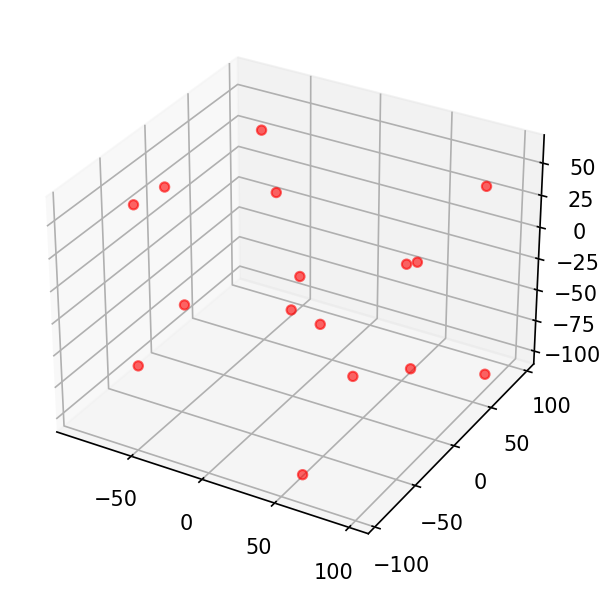

In [27]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], color='r', alpha=0.6, lw=1)

In [28]:
Options = {'poisson': True, 'original': False}


## Synapse Update algorithm

In [156]:
class Synapse:
    def __init__(self, coords):
        self.age = 0
        self.coords = coords
        self.nodes = None
        self.alive = True
        self.mature = False
    
    def age_flag(self):
        ms = self.age + 0.5
        alpha = 1/(self.age+1)
        color = 'r'
        if self.age > 5:
            ms = 6
            alpha = 0.25
            color = 'maroon'

        kwards = {'ms': ms,
                  'color': color,
                  'alpha': alpha
        }
        return kwards

def generate_random_point(point_cloud):
    R = point_cloud.radius
    h, k, l = point_cloud.center

    x = np.random.uniform(h-R, h+R)
    y = np.random.uniform(k-R, k+R)
    z = np.random.uniform(l-R, l+R)

    synapse = Synapse(np.array([x, y, z]))
    synapse.age = 0
    
    if (x-h)**2 + (y-k)**2 + (z-l)**2 <= R**2:
        return synapse
    else:
        return generate_random_point(point_cloud)

In [157]:
def generate_synapse(tree, point_cloud, Dk, Dg):

    synapse = generate_random_point(point_cloud=point_cloud)
    kdt = sp.spatial.KDTree([n.v for n in tree])
    d,inds = kdt.query(synapse.coords, distance_upper_bound=Dg*10)

    # enchance probability for synapses near the tree
    if d < Dg*10 and d > Dk:
        return synapse
    elif d > Dk:
        if np.random.rand() < 0.5:
            return synapse
        else:
            generate_synapse(tree, point_cloud, Dk, Dg)

def generate_synapses_by_density(tree, point_cloud, Dk, Dg, density, n_syn):
    synapses = poisson_sample(R_cloud=point_cloud.radius, 
                              syn_density=density, 
                              n_syn=n_syn, 
                              k=100)
    # synapses = np.array([Synapse(s) for s in synapses])
    kdt = sp.spatial.KDTree([n.v for n in tree])
    d,inds = kdt.query(synapses, distance_upper_bound=Dg*10)
    synapses = np.array([synapses[i] for i in inds])
    synapses = np.array([Synapse(s) for s in synapses])
    return synapses


def check_surroundings(synapse, list_synapses, repulsion=0.2):
    pos = synapse.coords
    dist = [spatial.distance.euclidean(pos, i.coords) for i in list_synapses]
    if np.all(np.array(dist) >= repulsion**2):
        return True

def update_synapses(tree, synapses, point_cloud, Dk, Dg, condition=None, life_cycle=45, syn_limit=10):
    new_synapses = list(synapses)

    # update the age of each synapse
    for s in new_synapses:
        if s.age > life_cycle:
            s.alive = False
        s.age += 1

    # set probability
    if condition == None: 
        def default_condition():
            return np.random.random() < 0.8
        condition = default_condition()

    while condition == True and len(new_synapses)<syn_limit:
        synapse = generate_synapse(tree, point_cloud, Dk, Dg)
        # if check_surroundings(synapse, new_synapses, repulsion=0.2):
        #     new_synapses.append(synapse)
        new_synapses.append(synapse)
        condition=default_condition()
    
    # clean the synapse list from not_alive or empty coords
    new_synapses = list(filter(lambda x: x.alive == True, synapses))
    new_synapses = list(filter(lambda x: x.coords.shape != np.array([]).shape, synapses))
    return np.array(new_synapses)

In [158]:
def space_colonization_synupd(tree, point_cloud, sources, iterations, Dg, Di, Dk, w_lim=400, upd_cycle = 100):
    roots = tree
    for r in roots:
        r.root = r
    Di = Di * Dg
    Dk = Dk * Dg
    w_lim = w_lim / Dg
    start_sources = len(sources)

    for j in tqdm(range(iterations)):
        node_label = None
        if j > upd_cycle:
            sources = update_synapses(tree, sources, point_cloud, Dk, Dg, condition=None, life_cycle=50, syn_limit=10)
            node_label = 5
        
        tree_prev = [n for n in tree if len(n.children) <= n.max_branches]
        kdt = sp.spatial.KDTree([n.v for n in tree_prev]) 
        sources_coords = [s.coords for s in sources]
        d,inds = kdt.query(sources_coords, distance_upper_bound=Di)
            
        if len(d) and np.min(d) > Di:
            d,inds = kdt.query(sources_coords, distance_upper_bound=np.min(d))
            
        for i, n in enumerate(tree_prev):
            S = sources[inds==i]
            S = [s.coords for s in S]
            n.spawn(S, Dg, label=node_label)
                    
        kdt2 = sp.spatial.KDTree([n.v for n in tree])
        too_close = kdt2.query_ball_point(sources_coords, Dk, return_length=True)        
        sources = sources[too_close == 0] 
        
        if not len(sources):
            break
        if all(r.weight > w_lim for r in roots):
            break
        # add small jitter to break up ties
        for s in sources:
            s.coords = s.coords + np.random.randn(*s.coords.shape)*Dg*0.05
    return tree, sources

In [214]:
R = 100
center = (2*R, 2*R, 2*R)
tree = set()
cloud = PointCloud(R=R, center=center, Npoints=1000)
sources = cloud.Sphere()

In [215]:
Dg = 1.5
steps = round(4*R/Dg)
upd_cycle = 50
sources_syn = np.array([Synapse(s) for s in sources])
# for s in sources_syn:
#     s.age = -upd_cycle
root = SCA.TreeNode(list(center), tree=tree)


In [216]:
steps

267

# Week 1

In [217]:
t1, s1 = space_colonization_synupd(
    tree=tree,
    point_cloud=cloud,
    sources=sources_syn,
    iterations = upd_cycle,
    Dg=Dg,
    Dk=4,
    Di=25,
    w_lim=10000,
    upd_cycle=upd_cycle)

  0%|          | 0/50 [00:00<?, ?it/s]

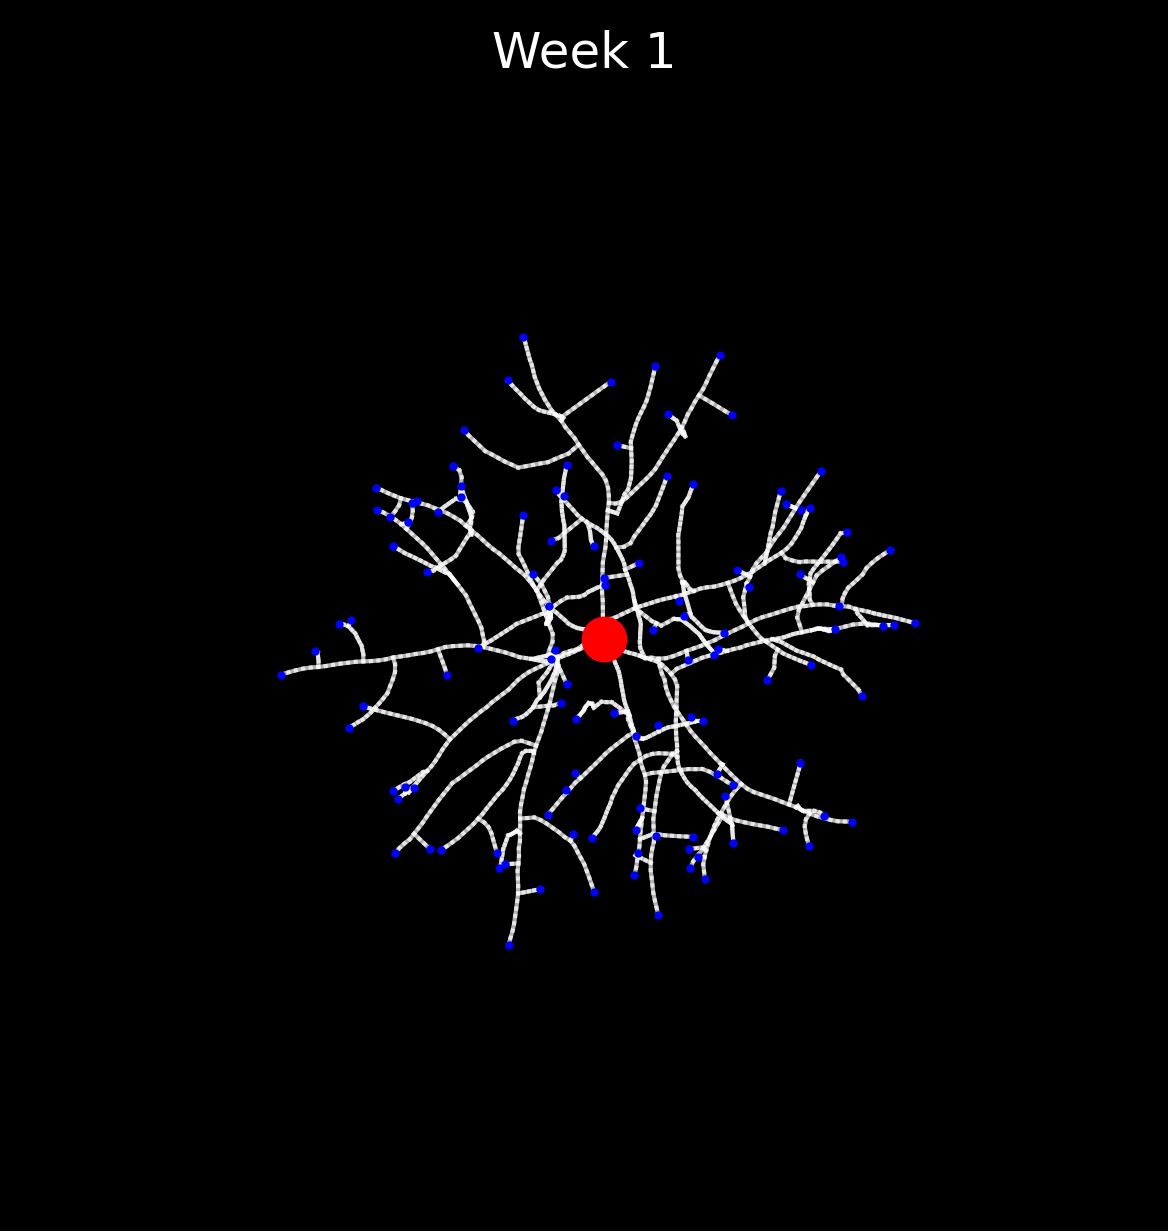

In [218]:
fig = plt.figure(dpi=300, facecolor='black')
ax = fig.add_subplot(projection='3d')
SCA.plot_tree(t1, root, show_leaflets=True, ax=ax, grid=False, color_tree='white', color_leaflets='b')
ax.set_title('Week 1', color='white')
ax.set_facecolor('black')
ax.plot(root.v[0], root.v[1], root.v[2], 'ro', ms=10)

# Week 2

In [219]:
len(s1)

815

In [220]:
cloud1 = PointCloud()
cloud1.CustomCloud([i.coords for i in s1])
t2, s2 = space_colonization_synupd(
    tree=t1,
    point_cloud=cloud1,
    sources=s1,
    iterations = upd_cycle,
    Dg=Dg,
    Dk=4,
    Di=100,
    w_lim=10000,
    upd_cycle=0)

  0%|          | 0/50 [00:00<?, ?it/s]

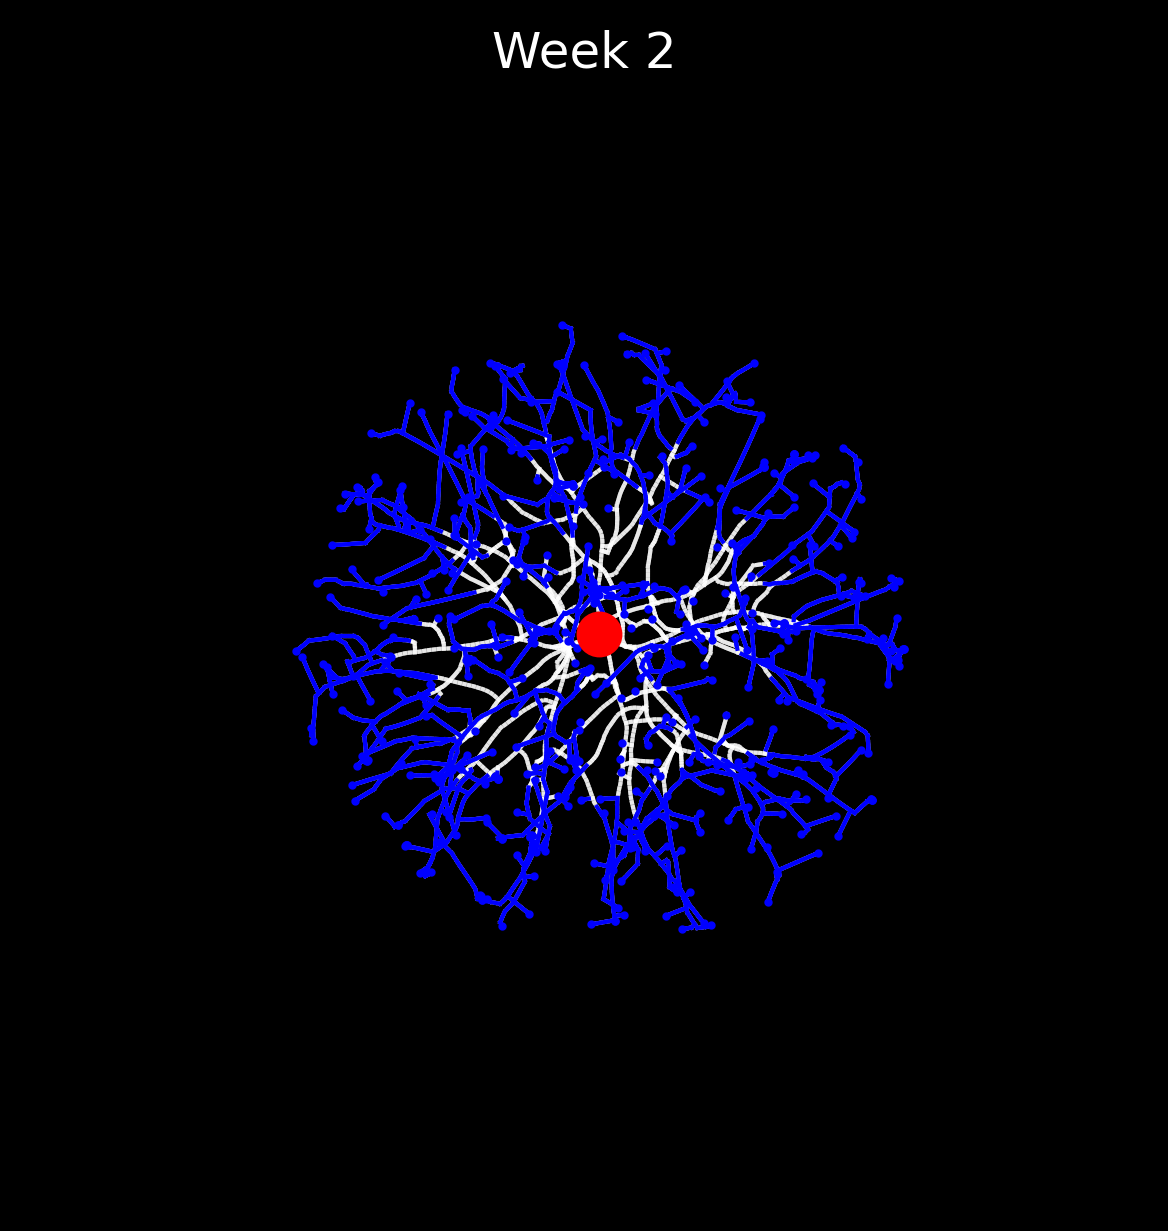

In [221]:
fig = plt.figure(dpi=300, facecolor='black')
ax = fig.add_subplot(projection='3d')
SCA.plot_tree(t2, root, show_leaflets=True, ax=ax, grid=False, color_tree='white', color_leaflets='b')
ax.set_title('Week 2', color='white')
ax.set_facecolor('black')
ax.plot(root.v[0], root.v[1], root.v[2], 'ro', ms=10)

In [222]:
len(s2)

25

# Week 3-4

In [223]:
cloud2 = PointCloud()
cloud2.CustomCloud([i.coords for i in s2])
t3, s3 = space_colonization_synupd(
    tree=t2,
    point_cloud=cloud2,
    sources=s2,
    iterations = 100,
    Dg=Dg,
    Dk=4,
    Di=100,
    w_lim=10000,
    upd_cycle=-1)


  0%|          | 0/100 [00:00<?, ?it/s]

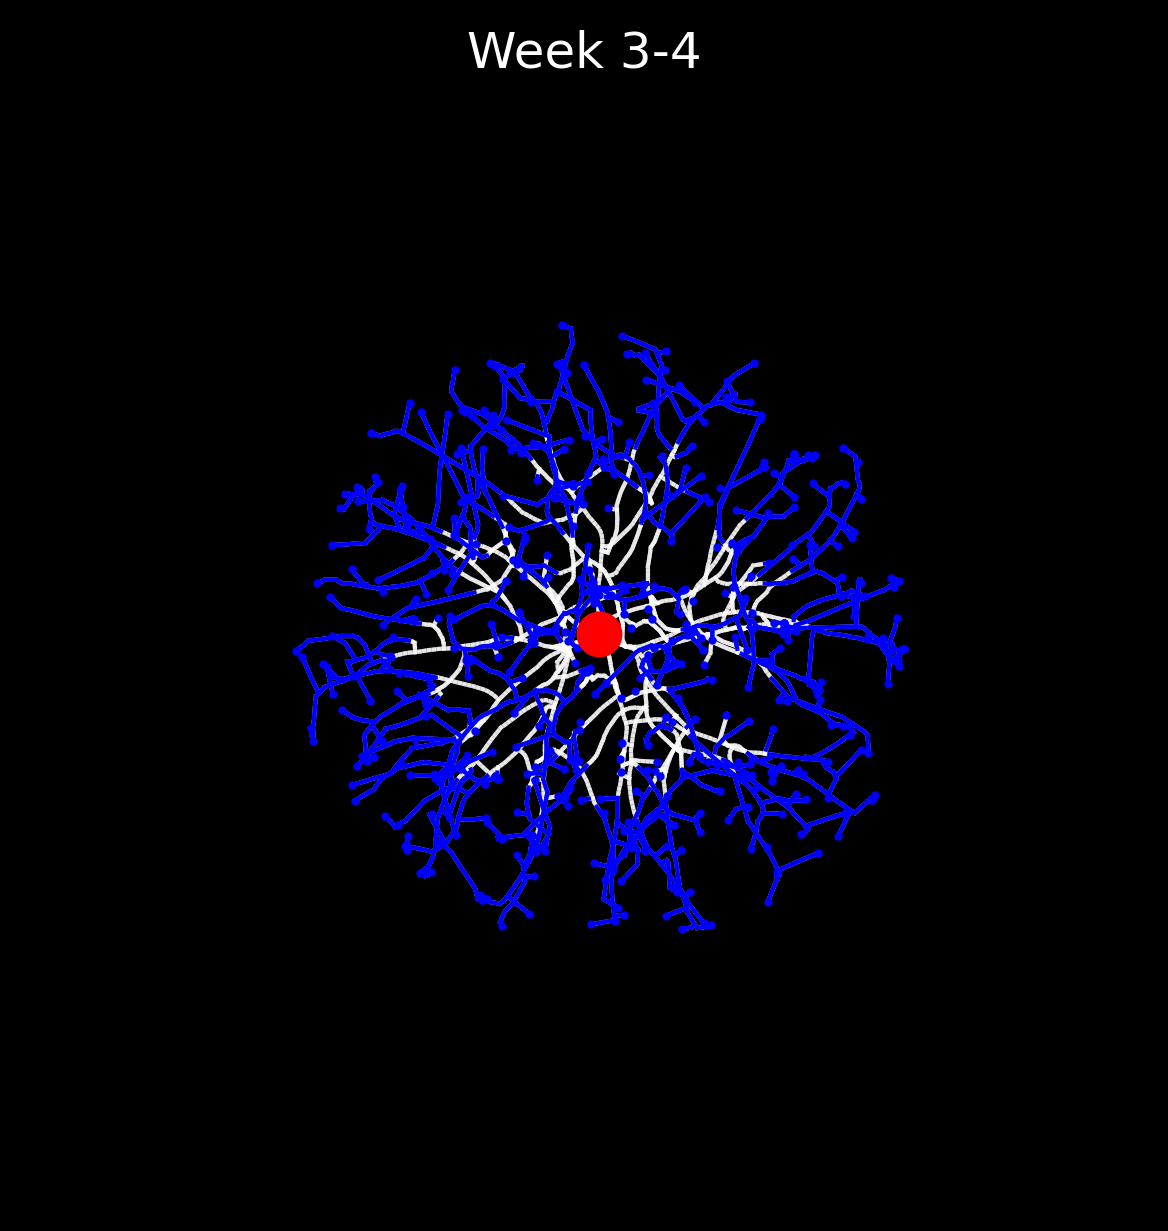

In [224]:
fig = plt.figure(dpi=300, facecolor='black')
ax = fig.add_subplot(projection='3d')
SCA.plot_tree(t3, root, show_leaflets=True, ax=ax, grid=False, color_tree='white', color_leaflets='b')
ax.set_title('Week 3-4', color='white')
ax.set_facecolor('black')
ax.plot(root.v[0], root.v[1], root.v[2], 'ro', ms=10)

In [225]:
s3

array([<__main__.Synapse object at 0x7f7f7787b1c0>,
       <__main__.Synapse object at 0x7f7f778c36d0>], dtype=object)

# Napari view

In [1]:
import napari
from skimage import data

# cells = data.cells3d()[30, 1]  # grab some data
# viewer = napari.view_image(cells, colormap='magma')

/Users/anyak/opt/anaconda3/envs/SemLab/lib/python3.10/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [7]:
cells = data.cells3d() #ZCYX image data

# load multichannel image in one line
viewer = napari.view_image(cells, channel_axis=1)

# load multichannel image in one line, with additional options
viewer = napari.view_image(
        cells,
        channel_axis=1,
        name=["membrane", "nuclei"],
        colormap=["green", "magenta"],
        contrast_limits=[[1000, 20000], [1000, 50000]],
        )

In [17]:
brain = data.hubble_deep_field()
viewer = napari.view_image(brain)

In [16]:
brain.shape

(16, 512, 512, 3)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp


In [36]:
arr1 = np.array(np.random.randint(2, 20, 20))
arr2 = np.array(np.random.randint(2, 20, 20))
arr3 = np.array(np.random.randint(2, 20, 20))

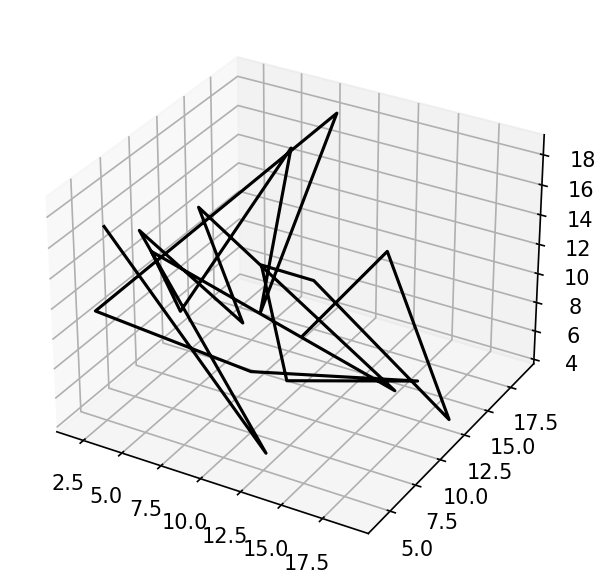

In [40]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.plot(arr1, arr2, arr3, color='k')